# Multivariate - Beyond the Basics

This notebook shows multivariate forecasting procedures with scalecast. It requires `0.18.2`. It uses the [Avocados dataset](https://www.kaggle.com/datasets/neuromusic/avocado-prices).  

We will treat this like a demand forecasting problem. We want to know how many total Avocados will be in demand in the next quarter. But since we know demand and price are intricately related, we will use the historical Avocado prices as a predictor of demand.  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.Pipeline import MVPipeline
from scalecast.util import (
    find_optimal_transformation, 
    find_optimal_lag_order, 
    break_mv_forecaster,
    backtest_metrics,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
)
from scalecast import GridGenerator

Read in hyperparameter grids for optimizing models.

In [2]:
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

In [3]:
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# arguments to pass to every Forecaster/MVForecaster object we create
Forecaster_kws = dict(
    test_length = 13,
    validation_length = 13,
    metrics = ['rmse','r2'],
)

In [5]:
# model summary columns to export everytime we check a model's performance
export_cols = ['ModelNickname','HyperParams','TestSetR2','TestSetRMSE']

In [6]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,51,2015-01-04,1.22,"40,873.28","2,819.50","28,287.42",49.90,"9,716.46","9,186.93",529.53,0.00,conventional,2015,Albany
50,50,2015-01-11,1.24,"41,195.08","1,002.85","31,640.34",127.12,"8,424.77","8,036.04",388.73,0.00,conventional,2015,Albany
49,49,2015-01-18,1.17,"44,511.28",914.14,"31,540.32",135.77,"11,921.05","11,651.09",269.96,0.00,conventional,2015,Albany
48,48,2015-01-25,1.06,"45,147.50",941.38,"33,196.16",164.14,"10,845.82","10,103.35",742.47,0.00,conventional,2015,Albany
47,47,2015-02-01,0.99,"70,873.60","1,353.90","60,017.20",179.32,"9,323.18","9,170.82",152.36,0.00,conventional,2015,Albany


In [7]:
# demand
vol = data.groupby('Date')['Total Volume'].sum()

In [8]:
# price
price = data.groupby('Date')['AveragePrice'].sum()

In [9]:
# one Forecaster object needed for each series we want to predict multivariately
# volume
fvol = Forecaster(
    y = vol,
    current_dates = vol.index,
    future_dates = 13,
    **Forecaster_kws,
)

In [10]:
# price
fprice = Forecaster(
    y = price,
    current_dates = price.index,
    future_dates = 13,
    **Forecaster_kws,
)

In [11]:
# combine Forecaster objects into one MVForecaster object
# all dates will line up and all models will recursively predict values for all series
mvf = MVForecaster(
    fvol,
    fprice,
    names=['volume','price'],
    **Forecaster_kws,
)

In [12]:
mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=[]
    TestLength=13
    ValidationLength=13
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

## 1. Transformations

To make the forecasting task easier, we can transform the data in each Forecaster object before feeding them to the MVForecaster object. The below function will search through many transformations, using out-of-sample testing to score each one. We pass four possible seasonalities to the function (monthly, quarterly, bi-annually, annually) and the results are several seasonal adjustments get selected.

In [13]:
transformers = []
reverters = []

for name, f in zip(('volume','price'),(fvol,fprice)):
    print(f'\nFinding best transformation for the {name} series.')
    transformer, reverter = find_optimal_transformation(
        f,
        m = [
            4,
            13,
            26,
            52,
        ],
        test_length = 13,
        num_test_sets = 2,
        space_between_sets = 13,
        return_train_only = True,
        verbose = True,
    )
    transformers.append(transformer)
    reverters.append(reverter)


Finding best transformation for the volume series.
Using mlr model to find the best transformation set on 2 test sets, each 13 in length.
All transformation tries will be evaluated with 4 lags.
Last transformer tried:
[]
Score (rmse): 19481972.64636622
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 22085767.144446835
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 19630858.294620857
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (rmse): 22320325.279892858
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 4, 'model': 'add'})]
Score (rmse): 18763298.437913556
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 4, 'model': 'add'}), ('DeseasonTrans

Plot the series after a transformation has been taken.

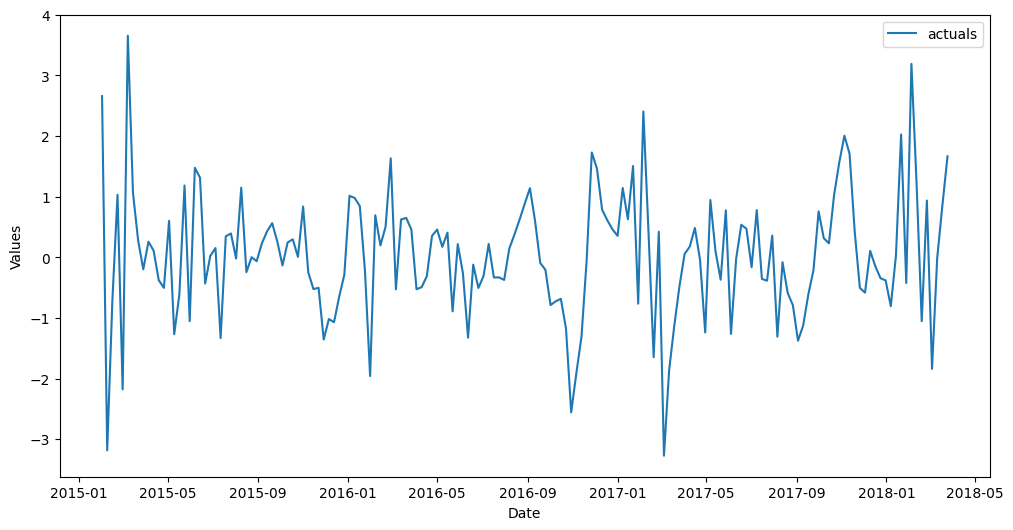

In [14]:
fvol1 = transformers[0].fit_transform(fvol)
fvol1.plot();

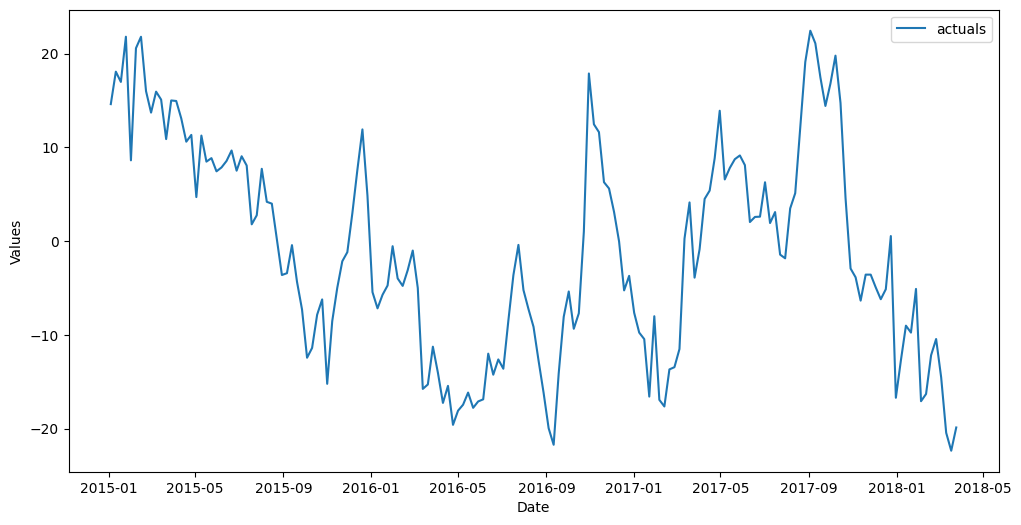

In [15]:
fprice1 = transformers[1].fit_transform(fprice)
fprice1.plot();

Now, combine into an `MVForecaster` object.

In [16]:
mvf1 = MVForecaster(
    fvol1,
    fprice1,
    names = ['volume','price'],
    **Forecaster_kws,
)

## 2. Optimal Lag Selection

### Method 1: Univariate out-of-sample testing
- The functions below choose the best lags based on what minimizes RMSE on an out-of-sample validation set.

In [17]:
fvol1.auto_Xvar_select(try_trend=False,try_seasonalities=False)
fvol1.get_regressor_names()

['AR1',
 'AR2',
 'AR3',
 'AR4',
 'AR5',
 'AR6',
 'AR7',
 'AR8',
 'AR9',
 'AR10',
 'AR11',
 'AR12',
 'AR13']

In [18]:
fprice1.auto_Xvar_select(try_trend=False,try_seasonalities=False)
fprice1.get_regressor_names()

['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11']

### Method 2: Information Criteria Search with VAR

In [19]:
lag_order_res = find_optimal_lag_order(mvf1,train_only=True)
lag_orders = pd.DataFrame({
    'aic':[lag_order_res.aic],
    'bic':[lag_order_res.bic],
})

lag_orders

,aic,bic
0,12,4


### Method 3: Multivariate Cross Validation with MLR

In [20]:
lags = [
    1,
    2,
    3,
    4,
    9,
    10,
    11,
    12,
    13,
    {'volume':13,'price':9},
    [4,9,12,13],
]

In [21]:
grid = dict(
    lags = lags
)

In [22]:
mvf1.set_optimize_on('volume')

In [23]:
mvf1.ingest_grid(grid)
mvf1.cross_validate(k=3,test_length=13,verbose = True,dynamic_tuning=True)

Num hyperparams to try for the mlr model: 11.
Fold 0: Train size: 139 (2015-02-01 00:00:00 - 2017-09-24 00:00:00). Test Size: 13 (2017-10-01 00:00:00 - 2017-12-24 00:00:00). 
Fold 1: Train size: 126 (2015-02-01 00:00:00 - 2017-06-25 00:00:00). Test Size: 13 (2017-07-02 00:00:00 - 2017-09-24 00:00:00). 
Fold 2: Train size: 113 (2015-02-01 00:00:00 - 2017-03-26 00:00:00). Test Size: 13 (2017-04-02 00:00:00 - 2017-06-25 00:00:00). 
Chosen paramaters: {'lags': 10}.


## 3. Model Optimization with Cross Validation

In [24]:
def forecaster(mvf):
    mvf.tune_test_forecast(
        ['lasso','ridge','xgboost','lightgbm'],
        cross_validate = True,
        k = 3,
        test_length = 13,
        dynamic_tuning=True,
        limit_grid_size=.2,
        min_grid_size=4,
    )
    
forecaster(mvf1)

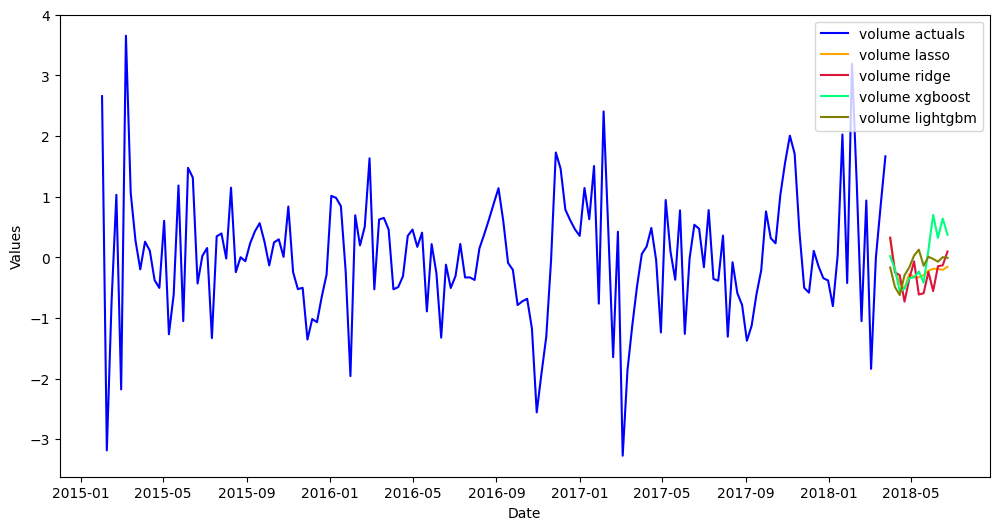

In [25]:
mvf1.plot(series='volume');

In [26]:
mvf1.export('model_summaries',series='volume')[['Series'] + export_cols + ['Lags']].style.set_properties(height = 5)

,Series,ModelNickname,HyperParams,TestSetR2,TestSetRMSE,Lags
0,volume,lasso,{'alpha': 0.02},-0.089158,1.399202,10
1,volume,ridge,{'alpha': 0.04},-0.050000,1.373819,10
2,volume,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 3, 'subsample': 0.8}",-0.017800,1.352589,10
3,volume,lightgbm,"{'n_estimators': 250, 'boosting_type': 'goss', 'max_depth': 2, 'learning_rate': 0.01}",-0.183962,1.458827,"[4, 9, 12, 13]"


In [27]:
mvf1

MVForecaster(
    DateStartActuals=2015-02-01T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=165
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=[]
    TestLength=13
    ValidationLength=13
    ValidationMetric=rmse
    ForecastsEvaluated=['lasso', 'ridge', 'xgboost', 'lightgbm']
    CILevel=None
    CurrentEstimator=lightgbm
    OptimizeOn=volume
    GridsFile=MVGrids
)

In [28]:
fvol1, fprice1 = break_mv_forecaster(mvf1)

In [29]:
reverter = reverters[0]
fvol1 = reverter.fit_transform(fvol1)

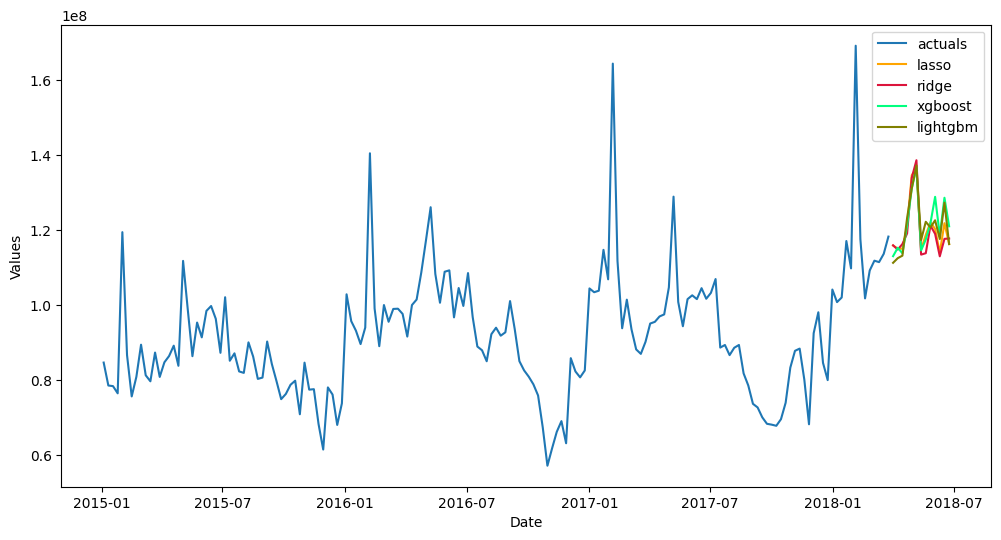

In [30]:
fvol1.plot();

In [31]:
fvol1.export('model_summaries')[export_cols].style.set_properties(height = 5)

,ModelNickname,HyperParams,TestSetR2,TestSetRMSE
0,lasso,{'alpha': 0.02},0.388886,13185802.986461
1,ridge,{'alpha': 0.04},0.249991,14607592.004013
2,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 3, 'subsample': 0.8}",0.455020,12451896.764192
3,lightgbm,"{'n_estimators': 250, 'boosting_type': 'goss', 'max_depth': 2, 'learning_rate': 0.01}",0.281993,14292550.306560


## 4. Model Stacking

In [32]:
def model_stack(mvf,train_only=False):
    mvf.add_signals(['lasso','ridge','lightgbm','xgboost'],train_only=train_only)
    mvf.set_estimator('catboost')
    mvf.manual_forecast(
        lags = 13,
        verbose = False,
    )
    
model_stack(mvf1,train_only=True)

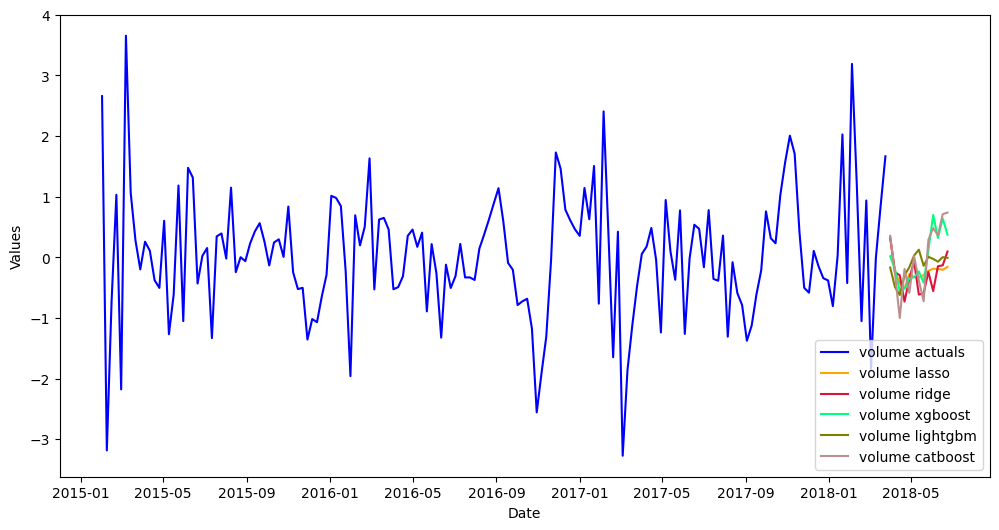

In [33]:
mvf1.plot(series='volume');

In [34]:
mvf1.export('model_summaries',series='volume')[['Series'] + export_cols + ['Lags']].style.set_properties(height = 5)

,Series,ModelNickname,HyperParams,TestSetR2,TestSetRMSE,Lags
0,volume,lasso,{'alpha': 0.02},-0.089158,1.399202,10
1,volume,ridge,{'alpha': 0.04},-0.050000,1.373819,10
2,volume,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 3, 'subsample': 0.8}",-0.017800,1.352589,10
3,volume,lightgbm,"{'n_estimators': 250, 'boosting_type': 'goss', 'max_depth': 2, 'learning_rate': 0.01}",-0.183962,1.458827,"[4, 9, 12, 13]"
4,volume,catboost,{'verbose': False},0.069340,1.293392,13


In [35]:
fvol1, fprice1 = break_mv_forecaster(mvf1)

In [36]:
fvol1 = reverter.fit_transform(fvol1)

In [37]:
fvol1.export('model_summaries',determine_best_by='TestSetRMSE')[export_cols].style.set_properties(height = 5)

,ModelNickname,HyperParams,TestSetR2,TestSetRMSE
0,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 3, 'subsample': 0.8}",0.455020,12451896.764192
1,catboost,{'verbose': False},0.447398,12538678.460293
2,lasso,{'alpha': 0.02},0.388886,13185802.986461
3,lightgbm,"{'n_estimators': 250, 'boosting_type': 'goss', 'max_depth': 2, 'learning_rate': 0.01}",0.281993,14292550.306560
4,ridge,{'alpha': 0.04},0.249991,14607592.004013


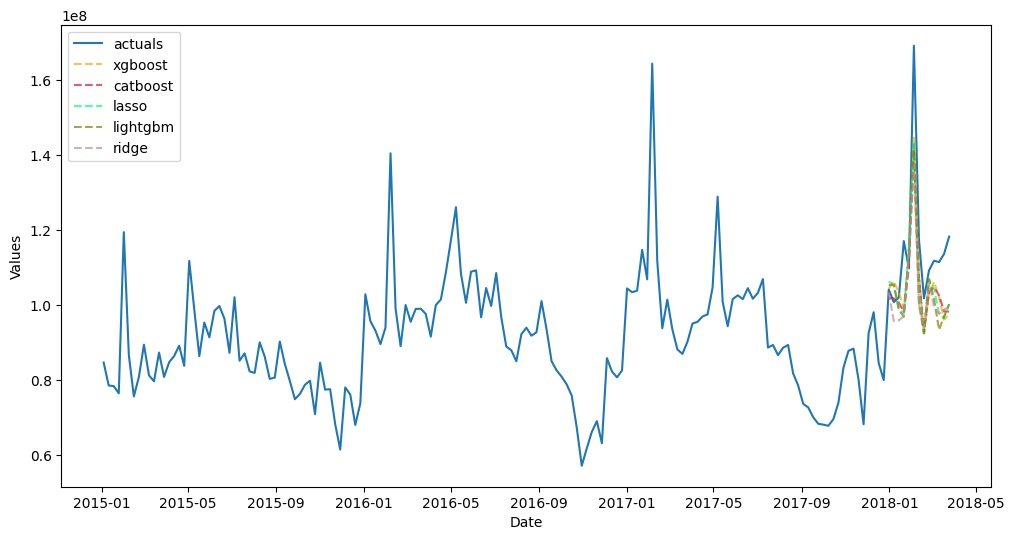

In [38]:
fvol1.plot_test_set(order_by='TestSetRMSE');

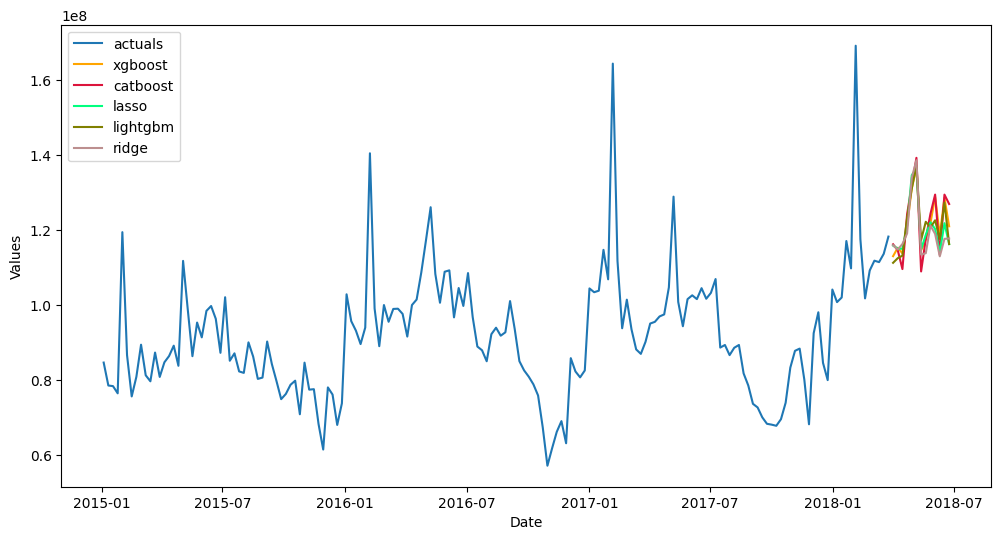

In [39]:
fvol1.plot(order_by='TestSetRMSE');

## 5. Multivariate Pipelines

In [40]:
def mvforecaster(mvf,train_only=False):
    forecaster(mvf)
    model_stack(mvf,train_only=train_only)

In [41]:
pipeline = MVPipeline(
    steps = [
        ('Transform',transformers),
        ('Forecast',mvforecaster),
        ('Revert',reverters),
    ],
    **Forecaster_kws,
)

In [42]:
fvol1, fprice1 = pipeline.fit_predict(fvol,fprice,train_only=True)

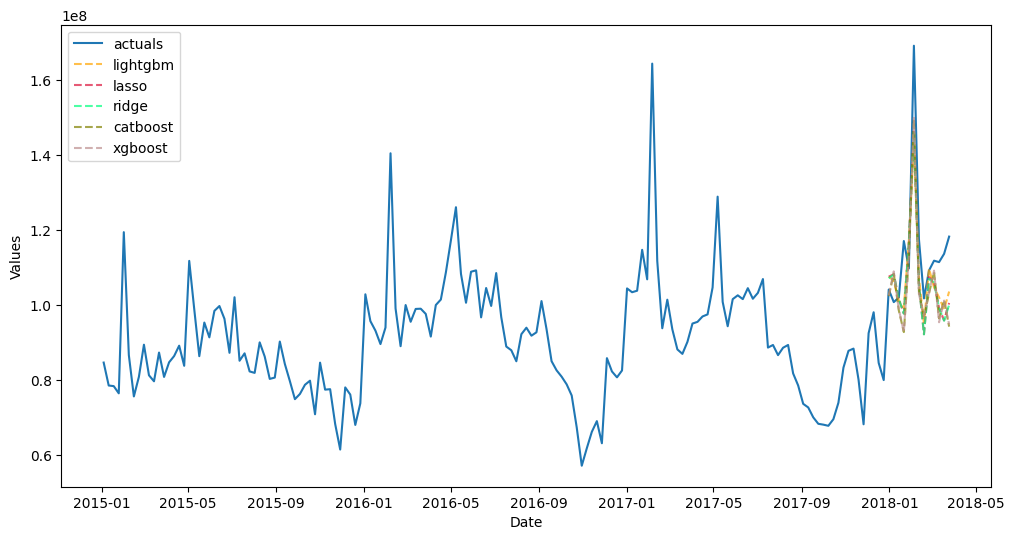

In [43]:
fvol1.plot_test_set(order_by='TestSetRMSE');

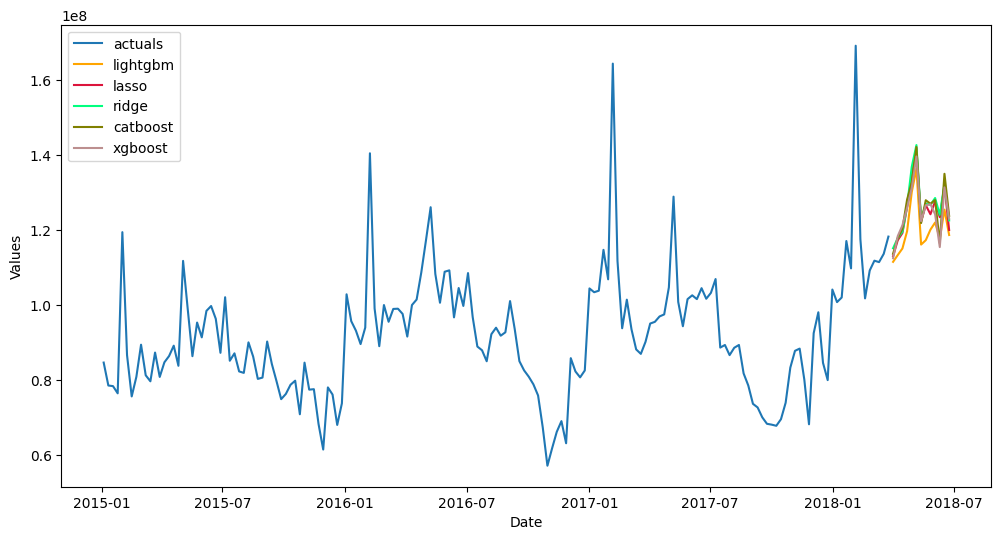

In [44]:
fvol1.plot(order_by='TestSetRMSE');

In [45]:
fvol1.export('model_summaries',determine_best_by='TestSetRMSE')[export_cols].style.set_properties(height = 5)

,ModelNickname,HyperParams,TestSetR2,TestSetRMSE
0,lightgbm,"{'n_estimators': 150, 'boosting_type': 'dart', 'max_depth': 1, 'learning_rate': 0.1}",0.511729,11786259.617968
1,lasso,{'alpha': 0.53},0.440399,12617822.749627
2,ridge,{'alpha': 1.0},0.433704,12693080.386907
3,catboost,{'verbose': False},0.384513,13232893.075803
4,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 10, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.8}",0.381760,13262451.219228


## 6. Backtesting

In [46]:
backtest_results = pipeline.backtest(
    fvol,
    fprice,
    n_iter = 4,
    fcst_length = 13,
    test_length = 0,
    jump_back = 13,
)

In [47]:
backtest_metrics(
    backtest_results[:1], # volume only
    mets=['rmse','mae','r2','bias'],
    #names=['volume','price'],
)

Iter0           Iter1          Iter2          Iter3  \
Model    Metric                                                                 
lasso    rmse     12,676,035.50   19,334,820.60  12,408,199.56   6,865,555.60   
         mae      10,622,259.32   16,818,913.78  10,196,006.95   4,890,701.26   
         r2                0.44           -2.98          -0.17           0.34   
         bias   -103,321,272.45 -216,135,991.11 106,453,214.29   7,242,071.64   
ridge    rmse     13,245,785.08   19,757,231.61  12,581,587.51   8,092,421.06   
         mae      10,864,770.69   17,175,778.82  10,362,478.27   6,239,668.77   
         r2                0.38           -3.16          -0.20           0.09   
         bias   -119,334,285.17 -221,927,247.43 109,823,042.50  55,636,823.14   
xgboost  rmse     19,261,511.73   15,233,136.06  15,781,395.08   6,583,385.75   
         mae      15,981,374.97   13,767,893.53  13,479,663.34   5,216,355.57   
         r2               -0.30           -1.47          -0.89           0.40   
         bias   -103,418,980.41 -151,259,604.70 155,235,475.90 -16,515,829.46   
lightgbm rmse     11,239,291.40   17,262,898.64  14,840,433.88   7,289,722.74   
         mae       9,087,987.10   15,146,134.37  12,373,711.83   5,735,222.10   
         r2                0.56           -2.17          -0.67           0.26   
         bias    -86,731,196.07 -189,464,392.96 140,926,488.55  43,025,640.10   
catboost rmse     17,455,804.71   14,955,271.67  16,116,336.26   6,315,491.61   
         mae      14,805,029.65   13,567,739.76  13,603,593.10   5,036,532.77   
         r2               -0.07           -1.38          -0.97           0.45   
         bias   -108,026,362.31 -146,926,722.77 162,948,970.47  24,860,226.70   

                       Average  
Model    Metric                 
lasso    rmse    12,821,152.81  
         mae     10,631,970.33  
         r2              -0.59  
         bias   -51,440,494.41  
ridge    rmse    13,419,256.32  
         mae     11,160,674.14  
         r2              -0.72  
         bias   -43,950,416.74  
xgboost  rmse    14,214,857.16  
         mae     12,111,321.85  
         r2              -0.57  
         bias   -28,989,734.67  
lightgbm rmse    12,658,086.67  
         mae     10,585,763.85  
         r2              -0.51  
         bias   -23,060,865.10  
catboost rmse    13,710,726.06  
         mae     11,753,223.82  
         r2              -0.50  
         bias   -16,785,971.98

## 7. Dynamic Intervals

In [48]:
backtest_results = backtest_for_resid_matrix(
    fvol,
    fprice,
    pipeline = pipeline,
    alpha = 0.1, # 90% intervals
)

In [49]:
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)

In [50]:
overwrite_forecast_intervals(
    fvol1,
    fprice1,
    backtest_resid_matrix=backtest_resid_matrix,
    alpha=0.1,
)

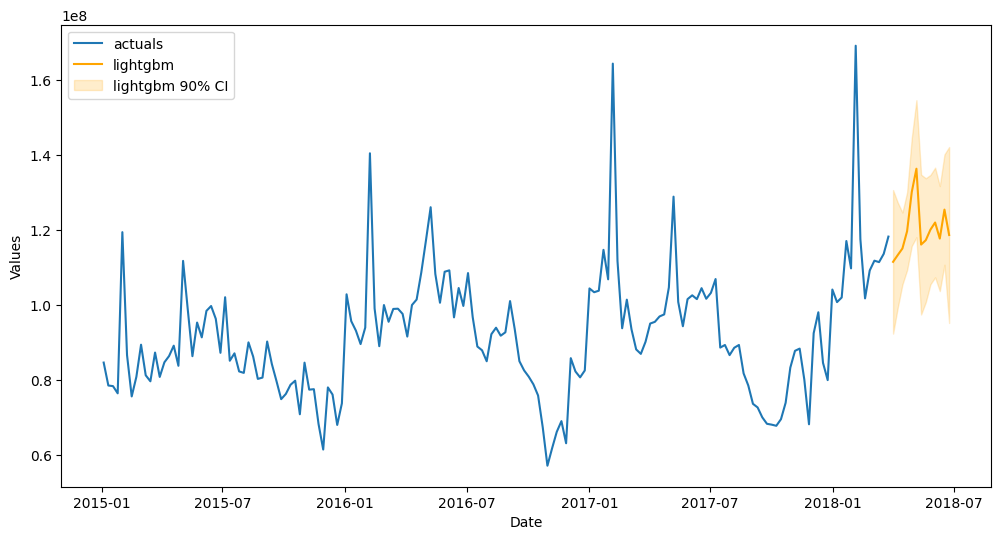

In [51]:
fvol1.plot(models='top_1',order_by='TestSetRMSE',ci=True);

## 8. LSTM Modeling

In [52]:
fvol1 = transformers[0].fit_transform(fvol1)
fprice1 = transformers[1].fit_transform(fprice1)

In [53]:
fvol1.add_ar_terms(13)

In [54]:
fvol1.set_estimator('rnn')
fvol1.tune()
fvol1.auto_forecast(call_me='lstm_uv')

In [55]:
fvol1.add_series(fprice1.y,called='price')
fvol1.add_lagged_terms('price',lags=13,drop=True)
fvol1

Forecaster(
    DateStartActuals=2015-02-01T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=165
    ForecastLength=13
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'pricelag_1', 'pricelag_2', 'pricelag_3', 'pricelag_4', 'pricelag_5', 'pricelag_6', 'pricelag_7', 'pricelag_8', 'pricelag_9', 'pricelag_10', 'pricelag_11', 'pricelag_12', 'pricelag_13']
    TestLength=13
    ValidationMetric=rmse
    ForecastsEvaluated=['lasso', 'ridge', 'xgboost', 'lightgbm', 'catboost', 'lstm_uv']
    CILevel=None
    CurrentEstimator=rnn
    GridsFile=Grids
)

In [56]:
fvol1.tune()
fvol1.auto_forecast(call_me='lstm_mv')

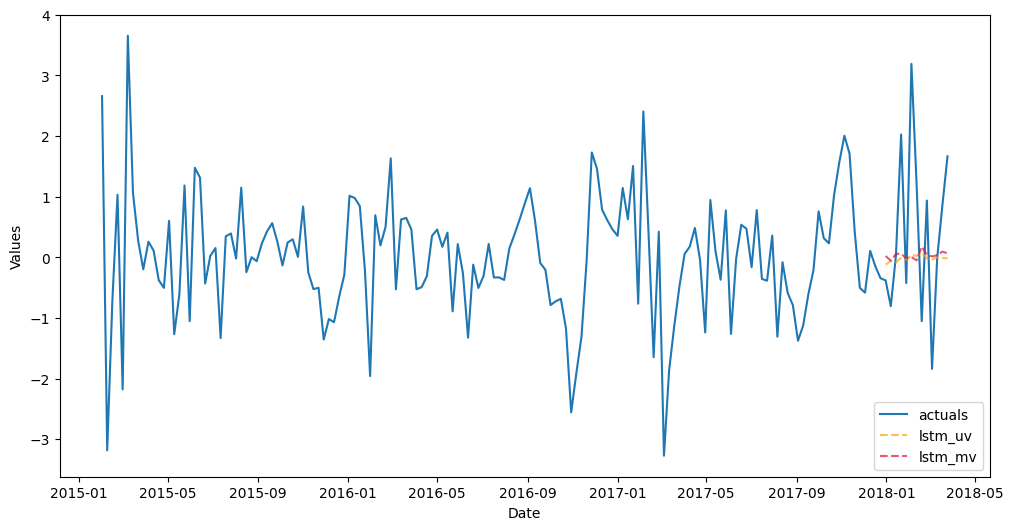

In [57]:
fvol1.plot_test_set(models=['lstm_uv','lstm_mv']);

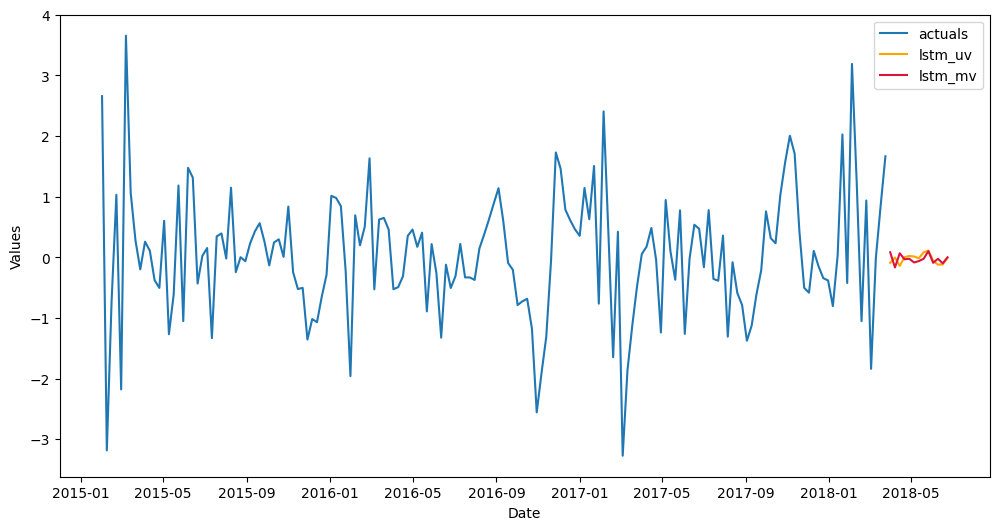

In [58]:
fvol1.plot(models=['lstm_uv','lstm_mv']);

In [59]:
fvol1 = reverters[0].fit_transform(fvol1,exclude_models=['lightgbm','lasso','ridge','xgboost','catboost'])
fprice1 = reverters[1].fit_transform(fprice1,exclude_models=['lightgbm','lasso','ridge','xgboost','catboost'])

In [60]:
ms = fvol1.export('model_summaries')
ms = ms[export_cols]
ms.style.set_properties(height = 5)

,ModelNickname,HyperParams,TestSetR2,TestSetRMSE
0,lasso,{'alpha': 0.53},0.440399,12617822.749627
1,ridge,{'alpha': 1.0},0.433704,12693080.386907
2,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 10, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.8}",0.381760,13262451.219228
3,lightgbm,"{'n_estimators': 150, 'boosting_type': 'dart', 'max_depth': 1, 'learning_rate': 0.1}",0.511729,11786259.617968
4,catboost,{'verbose': False},0.384513,13232893.075803
5,lstm_uv,"{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': False})], 'epochs': 50, 'verbose': 0}",0.449703,12512491.086281
6,lstm_mv,"{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': False})], 'epochs': 50, 'verbose': 0}",0.514143,11757086.227344


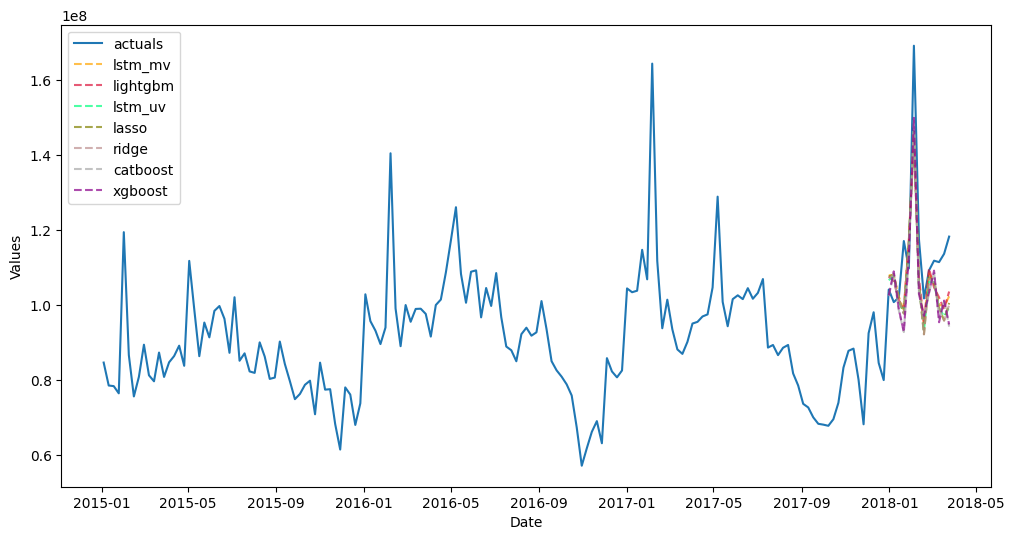

In [61]:
fvol1.plot_test_set(order_by = 'TestSetRMSE');

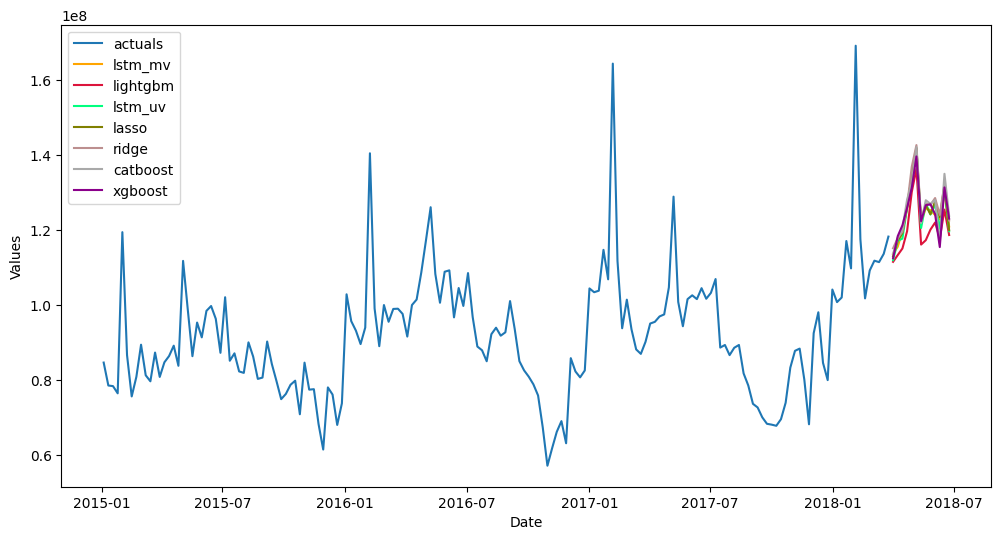

In [62]:
fvol1.plot(order_by = 'TestSetRMSE');

## 9. Benchmarking against Naive Model

In [63]:
fvol1 = transformers[0].fit_transform(fvol1)
fvol1.set_estimator('naive')
fvol1.manual_forecast()
fvol1 = reverters[0].fit_transform(fvol1,exclude_models=['lightgbm','lasso','ridge','xgboost','catboost','lstm_uv','lstm_mv'])

In [67]:
ms = fvol1.export('model_summaries',determine_best_by='TestSetRMSE')
ms = ms[export_cols]
ms.style.set_properties(height = 5)

,ModelNickname,HyperParams,TestSetR2,TestSetRMSE
0,lstm_mv,"{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'return_sequences': False})], 'epochs': 50, 'verbose': 0}",0.514143,11757086.227344
1,lightgbm,"{'n_estimators': 150, 'boosting_type': 'dart', 'max_depth': 1, 'learning_rate': 0.1}",0.511729,11786259.617968
2,lstm_uv,"{'layers_struct': [('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': True}), ('LSTM', {'units': 50, 'activation': 'tanh', 'dropout': 0.2, 'return_sequences': False})], 'epochs': 50, 'verbose': 0}",0.449703,12512491.086281
3,lasso,{'alpha': 0.53},0.440399,12617822.749627
4,ridge,{'alpha': 1.0},0.433704,12693080.386907
5,catboost,{'verbose': False},0.384513,13232893.075803
6,xgboost,"{'n_estimators': 250, 'scale_pos_weight': 10, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.8}",0.381760,13262451.219228
7,naive,{},-0.188041,18384892.054096


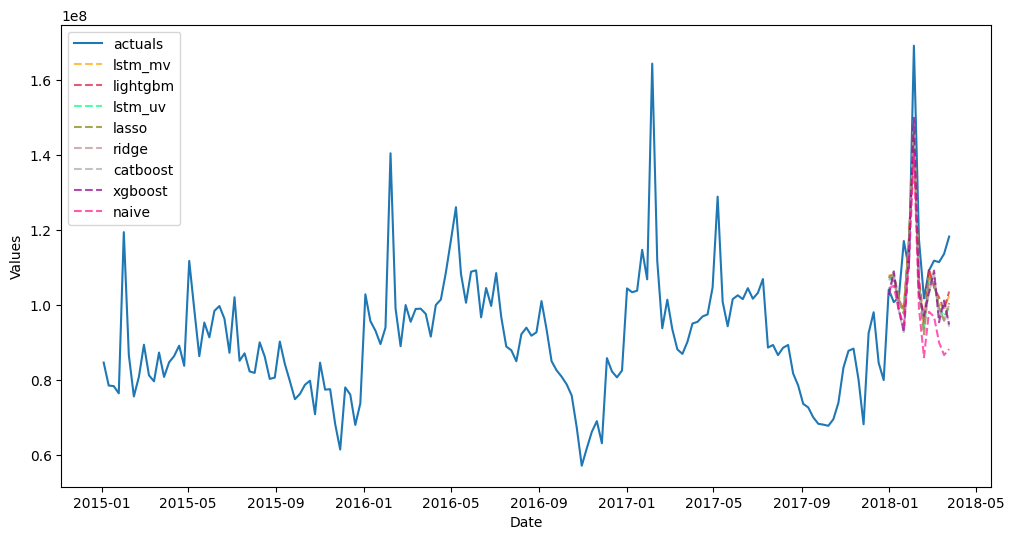

In [65]:
fvol1.plot_test_set(order_by = 'TestSetRMSE');

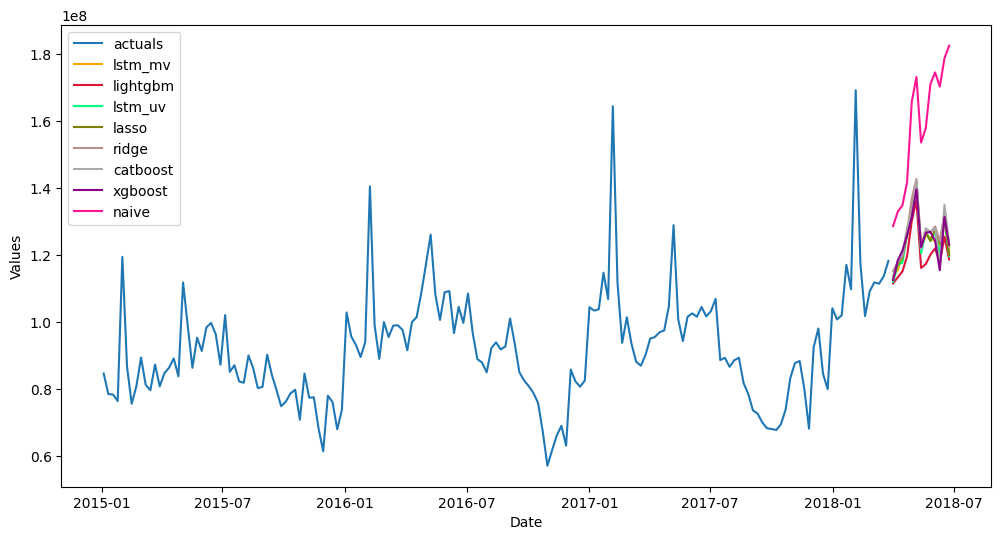

In [66]:
fvol1.plot(order_by = 'TestSetRMSE');